<a href="https://colab.research.google.com/github/kento-koyama/bayesian_predictive_micro_ICPMF12/blob/main/Workshop_(inactivation).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Modelling
##Load libraries.  
pystan: Bayesian MCMC  
nest_asyncio: Library for stan in notebook
pandas: Data manipulation  
numpy: Data calculation  
seaborn: Visualization  
matplotlib.pyplot: Visualization  
arviz: Visualization of pystan  

In [1]:
#!pip install -Uqq pystan==2.19.1.1
!pip install pystan
!pip install nest_asyncio
import nest_asyncio
nest_asyncio.apply()
import stan 
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import scipy
from scipy import stats
import math
import arviz as az
from sklearn.metrics import mean_squared_error
plt.rcParams['font.sans-serif'] = ['Arial'] 

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


#Data reading and preperation

The data imported from reported article through github: Hiura, S., Abe, H., Koyama, K. & Koseki, S. Bayesian generalized linear model for simulating bacterial inactivation/growth considering variability and uncertainty. Front. Microbiol. 12, 674364 (2021).

In [2]:
url = "https://raw.githubusercontent.com/Satoko-Hiura/Bayesian-generalized-linear-model-for-simulating-bacterial-inactivation-growth/main/code/inactivation/data/bayesian_fitting.csv"
data = pd.read_csv(url, encoding='utf-8')
TIME = data['TIME']
Nt = data['Nt']
Initial = data['Initial']

In [3]:
data

,TIME,Nt,Initial
0,0.000,84500,1
1,0.000,89000,2
2,0.000,78000,3
3,0.667,36200,0
4,0.667,37000,0
5,0.667,34750,0
6,1.333,14020,0
7,1.333,11935,0
8,1.333,17760,0
9,2.000,3332,0


#Model construction
stan_code includea the script for stan (C language).
stan scropt is constructed by several sections.

##data section
Define the data shape
##parameters section
Define the parameters and parameter shape
##model section
Define the following prior distribution

In [4]:
#parameter estimation
#compile

stan_code = """
  data {
    int M;
	  int<lower=0> Nt[M];
	  real TIME[M];
	  int Initial[M];
  }

  parameters {
	  real<lower=0> a;
	  real<lower=0> b;  
	  real<lower=0> n0;
  }

	


  model {
	  for (m in 1:M) {
		  if (Initial[m] != 0 ) {
			  Nt[Initial[m]] ~ poisson(n0);
		  }
	  }
    for (m in 1:M) {        
        Nt[m] ~ poisson(n0*(10^(-((TIME[m]/a)^b))));
    }
  }

"""



In [5]:
stan_data = data.to_dict('list')
stan_data.update({'M':len(data)})

In [6]:
posterior = stan.build(stan_code, data=stan_data)

Building...



Building: found in cache, done.Messages from stanc:
Warning in '/tmp/httpstan_5ye503mq/model_cklgpqa3.stan', line 4, column 3: Declaration
    of arrays by placing brackets after a variable name is deprecated and
    will be removed in Stan 2.32.0. Instead use the array keyword before the
    type. This can be changed automatically using the auto-format flag to
    stanc
Warning in '/tmp/httpstan_5ye503mq/model_cklgpqa3.stan', line 5, column 3: Declaration
    of arrays by placing brackets after a variable name is deprecated and
    will be removed in Stan 2.32.0. Instead use the array keyword before the
    type. This can be changed automatically using the auto-format flag to
    stanc
Warning in '/tmp/httpstan_5ye503mq/model_cklgpqa3.stan', line 6, column 3: Declaration
    of arrays by placing brackets after a variable name is deprecated and
    will be removed in Stan 2.32.0. Instead use the array keyword before the
    type. This can be changed automatically using the auto-format

In [7]:
#MCMC sampling
fit_nuts = posterior.sample(num_samples=2500, num_chains=4, num_warmup = 5000)

Sampling:   0%
Sampling:   3% (800/30000)
Sampling:   6% (1700/30000)
Sampling:  31% (9200/30000)
Sampling:  53% (15900/30000)
Sampling:  75% (22500/30000)
Sampling: 100% (30000/30000)
Sampling: 100% (30000/30000), done.
Messages received during sampling:
  Gradient evaluation took 4.3e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.43 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 3.3e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.33 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 1.1e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.11 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 8e-06 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.08 seconds.
  Adjust your expectations accordingly!


array([[<Axes: title={'center': 'a'}>, <Axes: title={'center': 'a'}>],
       [<Axes: title={'center': 'b'}>, <Axes: title={'center': 'b'}>],
       [<Axes: title={'center': 'n0'}>, <Axes: title={'center': 'n0'}>]],
      dtype=object)

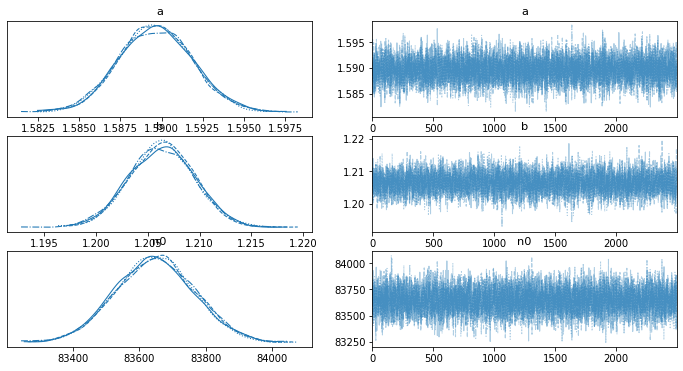

In [8]:
az.plot_trace(fit_nuts)

In [9]:
scale = fit_nuts['a'][0,:].T #scale parameter(δ)
shape = fit_nuts['b'][0,:].T #shape parameter(p)

In [10]:
#correlation
def corrfunc(x, y, **kws):
    r, _ = stats.spearmanr(x, y)
    ax = plt.gca()
    ax.axis('on')
    txtcolor = 'black' if math.fabs(r) < 0.5 else 'white'
    ax.text(.5, .5, 'Corr:\n{:.2f}'.format(r),color=txtcolor, fontsize=28, horizontalalignment='center', verticalalignment='center', transform=ax.transAxes)

/usr/local/lib/python3.9/dist-packages/seaborn/axisgrid.py:181: UserWarning: The label '_nolegend_' of <matplotlib.patches.Patch object at 0x7feffc6784f0> starts with '_'. It is thus excluded from the legend.
  figlegend = self._figure.legend(handles, labels, **kwargs)


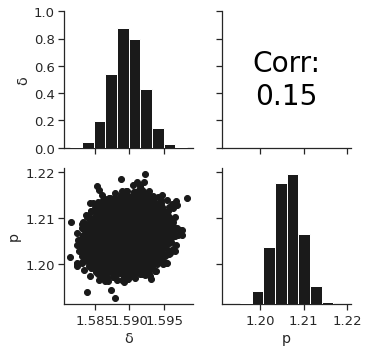

In [11]:
#pairplot
sns.set(style='ticks', font_scale=1.2)
d = pd.DataFrame({'δ':scale,'p':shape}, columns=['δ', 'p'])
g = sns.PairGrid(d)
g = g.map_diag(plt.hist,color='k')
g = g.map_lower(plt.scatter,color='k')
g = g.map_upper(corrfunc)
g = g.add_legend()

In [12]:
url = "https://raw.githubusercontent.com/Satoko-Hiura/Bayesian-generalized-linear-model-for-simulating-bacterial-inactivation-growth/main/code/inactivation/data/frequentism_fitting.csv"
data = pd.read_csv(url, encoding='utf-8')

t = data['TIME']
R = data['Ratio']

#fitting
parameter_initial = np.array([1.4,1.4])
def func(t, α, β):
    return -((t/α)**β)
parameter_optimal, covariance= scipy.optimize.curve_fit(func, t, R, p0=parameter_initial)
y = func(t, parameter_optimal[0], parameter_optimal[1])
print("scale parameter (α) =", format(parameter_optimal[0]))
print("shape parameter (β) =", format(parameter_optimal[1]))
RMSE = np.sqrt(mean_squared_error(R,y))
print("RMSE= ", format(RMSE))

#result of fitting
T = np.arange(0,6,0.05)
y = 4.9-((T/parameter_optimal[0])**parameter_optimal[1])


scale parameter (α) = 1.5848891703833252
shape parameter (β) = 1.2615817915254068
RMSE=  0.17570346625247327


In [13]:
#fitting by bayesian 
scale = fit_nuts['a'] #scale parameter(δ)
shape = fit_nuts['b'] #shape parameter(p)
N0 = 79000 #initial cell number

#time
T0 =[]
for n in range(61):
    t0 = n*0.1
    T0.append(t0)
T1 = pd.DataFrame(T0)

#confidence interval
y_conf_int = np.zeros((len(scale[0,:]),len(T0)))
for i in range(len(scale[0,:])):
    for j in range(len(T0)):
        y_conf_int[i,j] = N0*(10**(-((np.array(T0[j])/scale[0,i])**(shape[0,i]))))
y_conf_int_975 = np.percentile(y_conf_int, 2.5, axis=0)
y_conf_int_025 = np.percentile(y_conf_int, 97.5, axis=0)
y_conf_int_500 = np.percentile(y_conf_int, 50.0, axis=0)
y_conf = np.log10(y_conf_int)
y_conf_975 = np.percentile(y_conf, 2.5, axis=0)
y_conf_025 = np.percentile(y_conf, 97.5, axis=0)
y_conf_500 = np.percentile(y_conf, 50.0, axis=0)

#predicted interval
y_pred_int = np.zeros((len(scale[0,:]),len(T0)))
for i in range(len(scale[0,:])): 
    for j in range(len(T0)):    

        y_pred_int[i,j] = np.random.poisson(N0*10**(-((np.array(T0[j])/scale[0,i])**(shape[0,i]))))
y_pred_int_975 = np.percentile(y_pred_int, 2.5, axis=0)
y_pred_int_025 = np.percentile(y_pred_int, 97.5, axis=0)
y_pred_int_500 = np.percentile(y_pred_int, 50.0, axis=0)
y_pred = np.log10(y_pred_int)
y_pred_975 = np.percentile(y_pred, 2.5, axis=0)
y_pred_025 = np.percentile(y_pred, 97.5, axis=0)
y_pred_500 = np.percentile(y_pred, 50.0, axis=0)


<ipython-input-13-a9dffa504fc8>:35: RuntimeWarning: divide by zero encountered in log10
  y_pred = np.log10(y_pred_int)
/usr/local/lib/python3.9/dist-packages/numpy/lib/function_base.py:4486: RuntimeWarning: invalid value encountered in subtract
  diff_b_a = subtract(b, a)


/usr/local/lib/python3.9/dist-packages/pandas/core/arraylike.py:397: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


<Figure size 432x288 with 0 Axes>

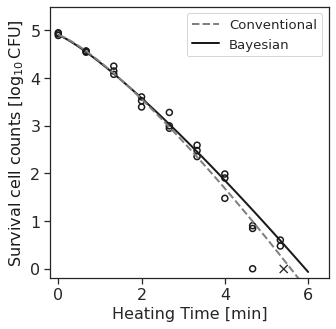

In [14]:
#graph
#plot+frequentism+bayes
url = "https://raw.githubusercontent.com/Satoko-Hiura/Bayesian-generalized-linear-model-for-simulating-bacterial-inactivation-growth/main/code/inactivation/data/bayesian_fitting.csv"
data2 = pd.read_csv(url, encoding='utf-8')
x = data2['TIME']
y1 = data2['Nt']
y1 = np.log10(y1)
fig = plt.figure()
plt.figure(figsize=(5,5))
sns.set_style(style='ticks')
plt.xlabel("Heating Time [min]", size=16)
plt.ylabel('Survival cell counts [$\log_{10}$CFU]',fontsize=16, color='k')
plt.tick_params(labelsize=16, direction='out')    
plt.xticks([0,2,4,6])
plt.xlim(-0.2,6.5)
plt.ylim(-0.2,5.5)
plt.plot(T, y, color="gray", linestyle='dashed', lw=2, zorder=2, label='Conventional')     
plt.text(5.25, -0.1, '×', fontsize=16)
plt.plot(T0,y_conf_500, linestyle = 'solid', zorder=1, color='k', lw=2.0, label='Bayesian')
plt.scatter(x, y1, facecolors='None', edgecolors='k',linewidths=1.5) 
plt.legend()
plt.show()

In [15]:

# data import
url = "https://raw.githubusercontent.com/Satoko-Hiura/Bayesian-generalized-linear-model-for-simulating-bacterial-inactivation-growth/main/code/inactivation/data/850cell.csv"
data = pd.read_csv(url, encoding='utf-8')
time = data['TIME']
N = data['N']

In [16]:
#prepare for prediction
#time 
T =[]
for n in range(121):
    t0 = n*0.05
    T.append(t0)

In [17]:

#prediction
N0 = 850 #initial cell number

y_pred_int = np.zeros((len(scale[0,:]),len(T)))
for i in range(len(scale[0,:])): 
    for j in range(len(T)):    
        y_pred_int[i,j] = np.random.poisson(N0*(10**(-((np.array(T[j])/scale[0,i])**(shape[0,i])))))
y_pred_int_975 = np.percentile(y_pred_int, 2.5, axis=0)
y_pred_int_025 = np.percentile(y_pred_int, 97.5, axis=0)
y_pred_int_500 = np.percentile(y_pred_int, 50.0, axis=0)
y_pred = np.log10(y_pred_int)
y_pred_975 = np.percentile(y_pred, 2.5, axis=0)
y_pred_025 = np.percentile(y_pred, 97.5, axis=0)
y_pred_500 = np.percentile(y_pred, 50.0, axis=0)

<ipython-input-17-2de04999fd00>:11: RuntimeWarning: divide by zero encountered in log10
  y_pred = np.log10(y_pred_int)
/usr/local/lib/python3.9/dist-packages/numpy/lib/function_base.py:4486: RuntimeWarning: invalid value encountered in subtract
  diff_b_a = subtract(b, a)


In [18]:

#confidence interval
y_conf_int = np.zeros((len(scale[0,:]),len(T)))
for i in range(len(scale)):
    for j in range(len(T)):
        y_conf_int[i,j] = N0*(10**(-((np.array(T[j])/scale[0,i])**(shape[0,i]))))

y_conf_int_975 = np.percentile(y_conf_int, 2.5, axis=0)
y_conf_int_025 = np.percentile(y_conf_int, 97.5, axis=0)
y_conf_int_500 = np.percentile(y_conf_int, 50.0, axis=0)
y_conf = np.log10(y_conf_int)
y_conf_975 = np.percentile(y_conf, 2.5, axis=0)
y_conf_025 = np.percentile(y_conf, 97.5, axis=0)
y_conf_500 = np.percentile(y_conf, 50.0, axis=0)

<ipython-input-18-3a7b9716960b>:10: RuntimeWarning: divide by zero encountered in log10
  y_conf = np.log10(y_conf_int)


In [19]:
y_conf_int

array([[8.50000000e+02, 8.20446436e+02, 7.83315853e+02, ...,
        1.14476313e-02, 1.02057904e-02, 9.09684498e-03],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       ...,
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00]])

In [20]:
#accuracy
Time = [3.0,3.3,3.6,4.0,4.3,4.6]
k=[0,1,2,3,4,5]
evaluation =[]
for t,k in zip(Time,k):
    T1 = int(t*20)
    y_pred_min = y_pred_int_975[T1]
    y_pred_max = y_pred_int_025[T1]
    hani =[]
    for l in range(60):
        number = 60*k + l
        N_target = N[number]
        if y_pred_min <= N_target <= y_pred_max :  
            ans= 1
        else:
            ans=0
        hani.append(ans)
    correct =hani.count(1)
    evaluation.append(correct)
accuracy = (sum(evaluation)/(len(Time)*60))*100

/usr/local/lib/python3.9/dist-packages/pandas/core/arraylike.py:397: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


<Figure size 432x288 with 0 Axes>

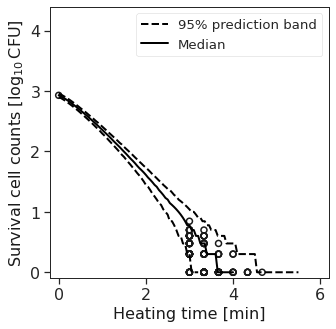

In [21]:

#graph
fig = plt.figure()
plt.style.use('ggplot')
sns.set_style(style='ticks')
plt.figure(figsize=(5,5))
plt.ylabel('Survival cell counts [$\log_{10}$CFU]',fontsize=16, color='k')
plt.xlabel('Heating time [min]', fontsize=16, color='k')
plt.tick_params(labelsize=16, direction='out')
plt.xlim(-0.2,6.2)
plt.ylim(-0.1,4.4)
plt.xticks([0,2,4,6])
plt.scatter(0,np.log10(N0),zorder=2,facecolors='none', edgecolors='k',lw=1.5)
plt.scatter(time,np.log10(N), zorder=2, facecolors ='none',edgecolors='k',linewidth=1.5)

#prediction interval
plt.plot(T,y_pred_025, linestyle = 'dashed', zorder=2, color='black', lw=2.0, label='95% prediction band')
plt.plot(T,y_pred_975, linestyle = 'dashed', zorder=2, color='black', lw=2.0)
plt.plot(T,y_pred_500, linestyle = 'solid', zorder=2, color='black', lw=2.0, label='Median')

plt.legend()
plt.show()